# Генетический алгоритм

In [60]:
import pandas as pd
import geopandas as gpd

matrix = pd.read_csv('matrix.csv')
matrix = matrix.astype(int)
schools = gpd.read_file('schools.geojson')

In [61]:
matrix_25 = pd.read_csv('matrix_25.csv')
matrix_50 = pd.read_csv('matrix_50.csv')
matrix_125 = pd.read_csv('matrix_125.csv')
matrix_250 = pd.read_csv('matrix_250.csv')

In [69]:
import math
import random
import matplotlib.pyplot as plt


class SimulatedAnnealing:
    def __init__(self, temp, alpha, stopping_temp, stopping_iter, dist_matrix):

        self.sample_size = len(dist_matrix)
        self.temp = temp
        self.alpha = alpha
        self.stopping_temp = stopping_temp
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.dist_matrix = dist_matrix
        self.curr_solution = [i for i in range(0, len(dist_matrix))]
        self.best_solution = self.curr_solution

        self.solution_history = [self.curr_solution]

        self.curr_weight = self.weight(self.curr_solution)
        self.initial_weight = self.curr_weight
        self.min_weight = self.curr_weight

        self.weight_list = [self.curr_weight]

    def weight(self, sol):
        return sum([self.dist_matrix[i][j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def acceptance_probability(self, candidate_weight):
        return math.exp(-abs(candidate_weight - self.curr_weight) / self.temp)

    def accept(self, candidate):

        candidate_weight = self.weight(candidate)
        if candidate_weight < self.curr_weight:
            self.curr_weight = candidate_weight
            self.curr_solution = candidate
            if candidate_weight < self.min_weight:
                self.min_weight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.acceptance_probability(candidate_weight):
                self.curr_weight = candidate_weight
                self.curr_solution = candidate

    def anneal(self):
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.curr_solution)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.alpha
            self.iteration += 1
            self.weight_list.append(self.curr_weight)
            self.solution_history.append(self.curr_solution)


def run_algorithm(params, matrix):
    temp, alpha, stopping_temp, stopping_iter = params
    sa = SimulatedAnnealing(temp, alpha, stopping_temp, stopping_iter, matrix.values.tolist())
    sa.anneal()
    best_fitness = sa.min_weight
    params = params
    logbook = sa.weight_list
    best_path = sa.best_solution
    return best_fitness, params, logbook, best_path

In [97]:
import itertools
import random
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

t_max = [100,500,1000,1500,2000]
alpha = [.4, .5, .6, .7, .8, .9, .95]
t_min = [.1, 1,5,10]
generations = [100, 200, 300]

param_grid = list(
    itertools.product(t_max, alpha, t_min, generations))
random.seed(10)
results = Parallel(n_jobs=-1)(
    delayed(run_algorithm)(params, matrix_25) for params in param_grid * 10)  #n_jobs - кол-во ядер процессора
best_result = min(results, key=lambda x: x[0])
best_fitness = best_result[0]
best_params = best_result[1]
best_path = best_result[3]
print(f"Лучшие параметры: {best_params} с результатом: {best_fitness}")

Лучшие параметры: (1500, 0.95, 0.1, 300) с результатом: 145862


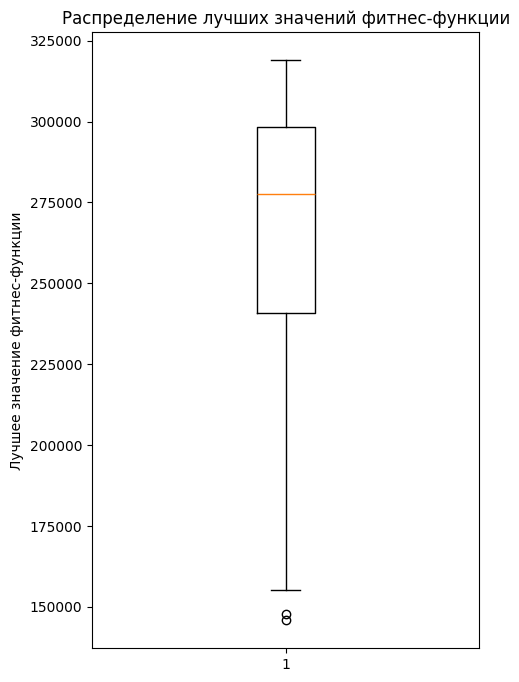

In [98]:
fig = plt.figure(figsize=(5, 8))
best_fitness_values = [result[0] for result in results]
plt.boxplot(best_fitness_values)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()

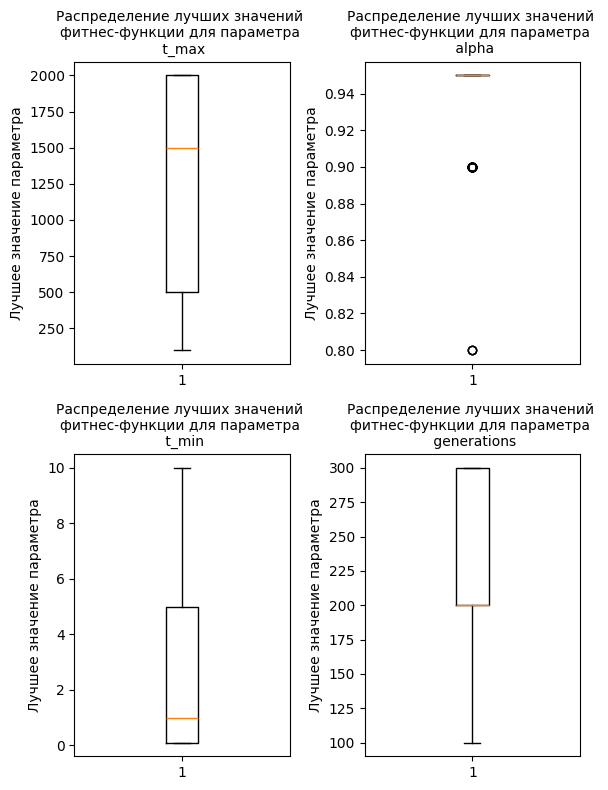

In [101]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Собираем лучшие значения фитнес-функции для каждого параметра
best_fitness_values = [result[1] for result in results if 0 < result[0] < 200000]

# Создаем график "ящик с усами" для каждого параметра
fig, axs = plt.subplots(2, 2, figsize=(6, 8))

titles = ["t_max", "alpha", "t_min", "generations"]
locators = [1000, .01, 1000, 10]

for i in range(len(best_fitness_values[0])):
    row = i // len(axs[0])
    col = i % len(axs[0])
    axs[row, col].boxplot([bfv[i] for bfv in best_fitness_values])
    axs[row, col].set_title(f"Распределение лучших значений \nфитнес-функции для параметра \n {titles[i]}",
                            fontdict={'fontsize': 10})
    # axs[row, col].yaxis.set_major_locator(ticker.MultipleLocator(locators[i]))
    axs[row, col].set_ylabel("Лучшее значение параметра")
plt.tight_layout()
plt.show()

Лучшие параметры: (2000, 0.95, 1, 300) с результатом: 6216800


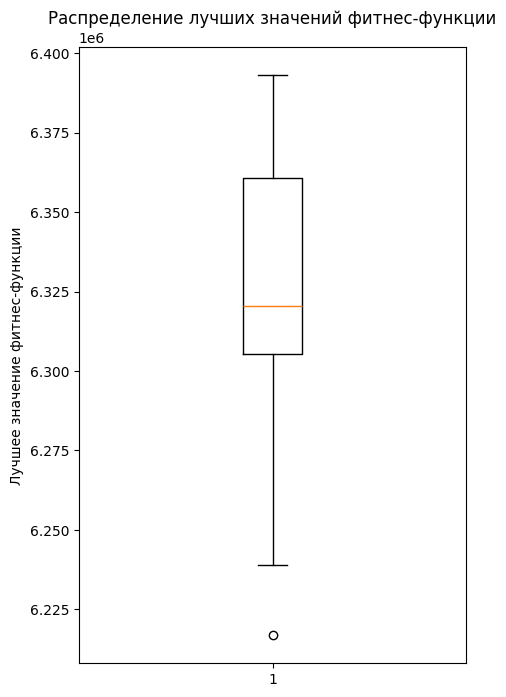

In [132]:
import itertools
import random
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

t_max = [2000]
alpha = [.95]
t_min = [1]
generations = [300 for i in range(10)]

param_grid = list(
    itertools.product(t_max, alpha, t_min, generations))
random.seed(10)
results = Parallel(n_jobs=-1)(
    delayed(run_algorithm)(params, matrix) for params in param_grid)  #n_jobs - кол-во ядер процессора
best_result = min(results, key=lambda x: x[0])
best_fitness = best_result[0]
best_params = best_result[1]
best_path = best_result[3]
print(f"Лучшие параметры: {best_params} с результатом: {best_fitness}")

fig = plt.figure(figsize=(5, 8))
best_fitness_values = [result[0] for result in results]
plt.boxplot(best_fitness_values)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()

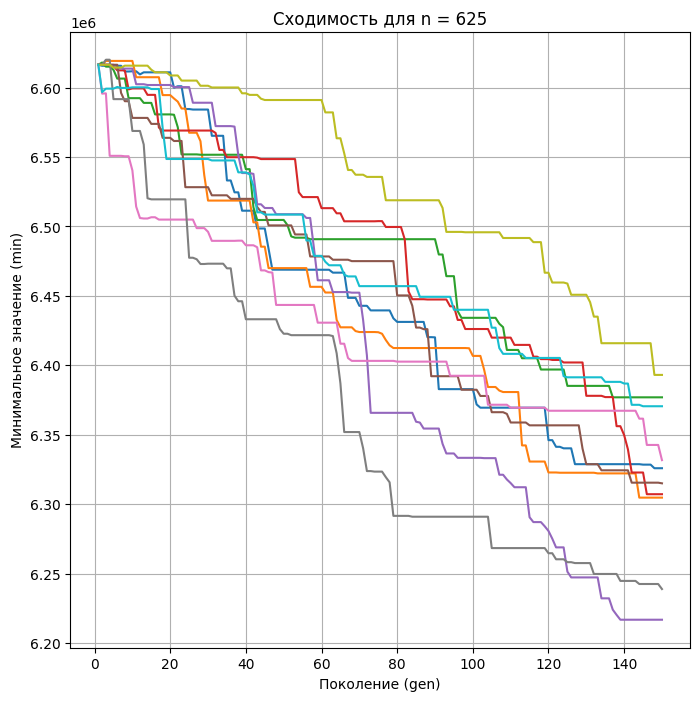

In [136]:
mins_all = [result[2] for result in results]
gens_all = [[x for x in range(1,len(result[2])+1)] for result in results]
plt.figure(figsize=(8, 8))
# Построй график
for mins, gens in zip(mins_all, gens_all):
    plt.plot(gens, mins)
# Настройка осей и заголовка
plt.xlabel('Поколение (gen)')
plt.ylabel('Минимальное значение (min)')
plt.title('Сходимость для n = 625')
# Отображение сетки
plt.grid(True)
# Отображение графика
plt.show()

In [135]:
[x[0] for x in results]

[6325878,
 6304710,
 6376929,
 6307172,
 6216800,
 6315007,
 6331703,
 6238883,
 6393068,
 6370506]

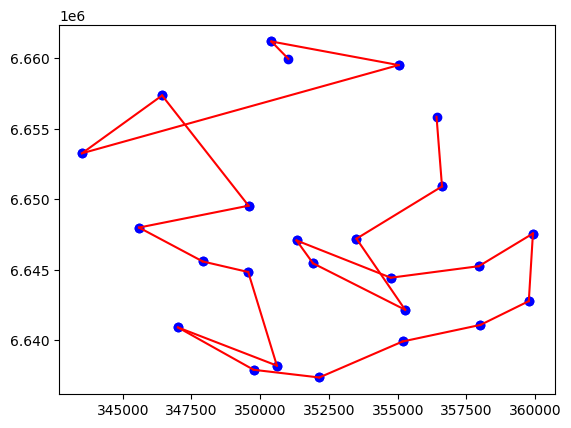

In [82]:
import matplotlib.pyplot as plt

mapping = {i: matrix_25.index.values[i] for i in range(0, matrix_25.shape[0])}
path = [int(mapping.get(i)) for i in best_path]
plt.figure(dpi=100)
for i in range(len(path) - 1):
    node1 = schools.iloc[path[i]]['geometry']
    node2 = schools.iloc[path[i + 1]]['geometry']
    plt.plot(*zip((node1.x, node1.y), (node2.x, node2.y)), color='red')
    plt.scatter([node1.x, node2.x], [node1.y, node2.y], color='blue')